In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Reload modules to get latest changes
import importlib
import params
import agents
import model

params = importlib.reload(params)
agents = importlib.reload(agents)
model = importlib.reload(model)

from model import NewsVendorModel


Computing optimal benchmarks (this may take a moment)...
Supplier global optimum: cost=2.00, quantity=40, profit=0.00
Retailer optimal at manufacturing cost (c=2.00): price=17.50, quantity=40


In [2]:
# Configure partner prediction mode
params.USE_PARTNER_PREDICTION = False  # False = basic, True = sophisticated
params.SUPPLIER_TEAM_PLAYER = True

# Run simulation with greedy agents
agent_types = ['greedy', 'greedy', 'greedy']
model = NewsVendorModel(agent_type=agent_types)

for i in range(params.ROUNDS):
    model.step()

# Pull data 
model_df = model.datacollector.get_model_vars_dataframe()
agent_df = model.datacollector.get_agent_vars_dataframe()

In [3]:
# View agent data
agent_df

Action      Reward  Cummulative Reward  Cummulative Regret  \
Step  AgentID                                                               
1.0   1          29.0  -27.132047          -27.132047          564.951414   
      2          36.0  -27.132047          -27.132047          564.951414   
      3           2.0    0.000000            0.000000            0.000000   
2.0   1          13.0  220.000000          192.867953          882.770781   
      2          20.0  220.000000          192.867953          882.770781   
...               ...         ...                 ...                 ...   
364.0 2          32.0  371.378144       113698.016541        82068.233085   
      3           2.0    0.000000            0.000000            0.000000   
365.0 1          19.0  544.000000       114242.016541        82062.052452   
      2          32.0  544.000000       114242.016541        82062.052452   
      3           2.0    0.000000            0.000000            0.000000   

                   Role  
Step  AgentID            
1.0   1           price  
      2        quantity  
      3        supplier  
2.0   1           price  
      2        quantity  
...                 ...  
364.0 2        quantity  
      3        supplier  
365.0 1           price  
      2        quantity  
      3        supplier  

[1095 rows x 5 columns]

In [4]:
# View model data
model_df

,Regret,Demand
0,564.951414,1.547171
1,317.819367,44.100159
2,452.311264,4.254512
3,196.819367,63.905647
4,224.615173,22.739648
...,...,...
360,-5.701352,31.974775
361,-6.180633,37.333939
362,-6.180633,43.498242
363,166.441223,22.914639


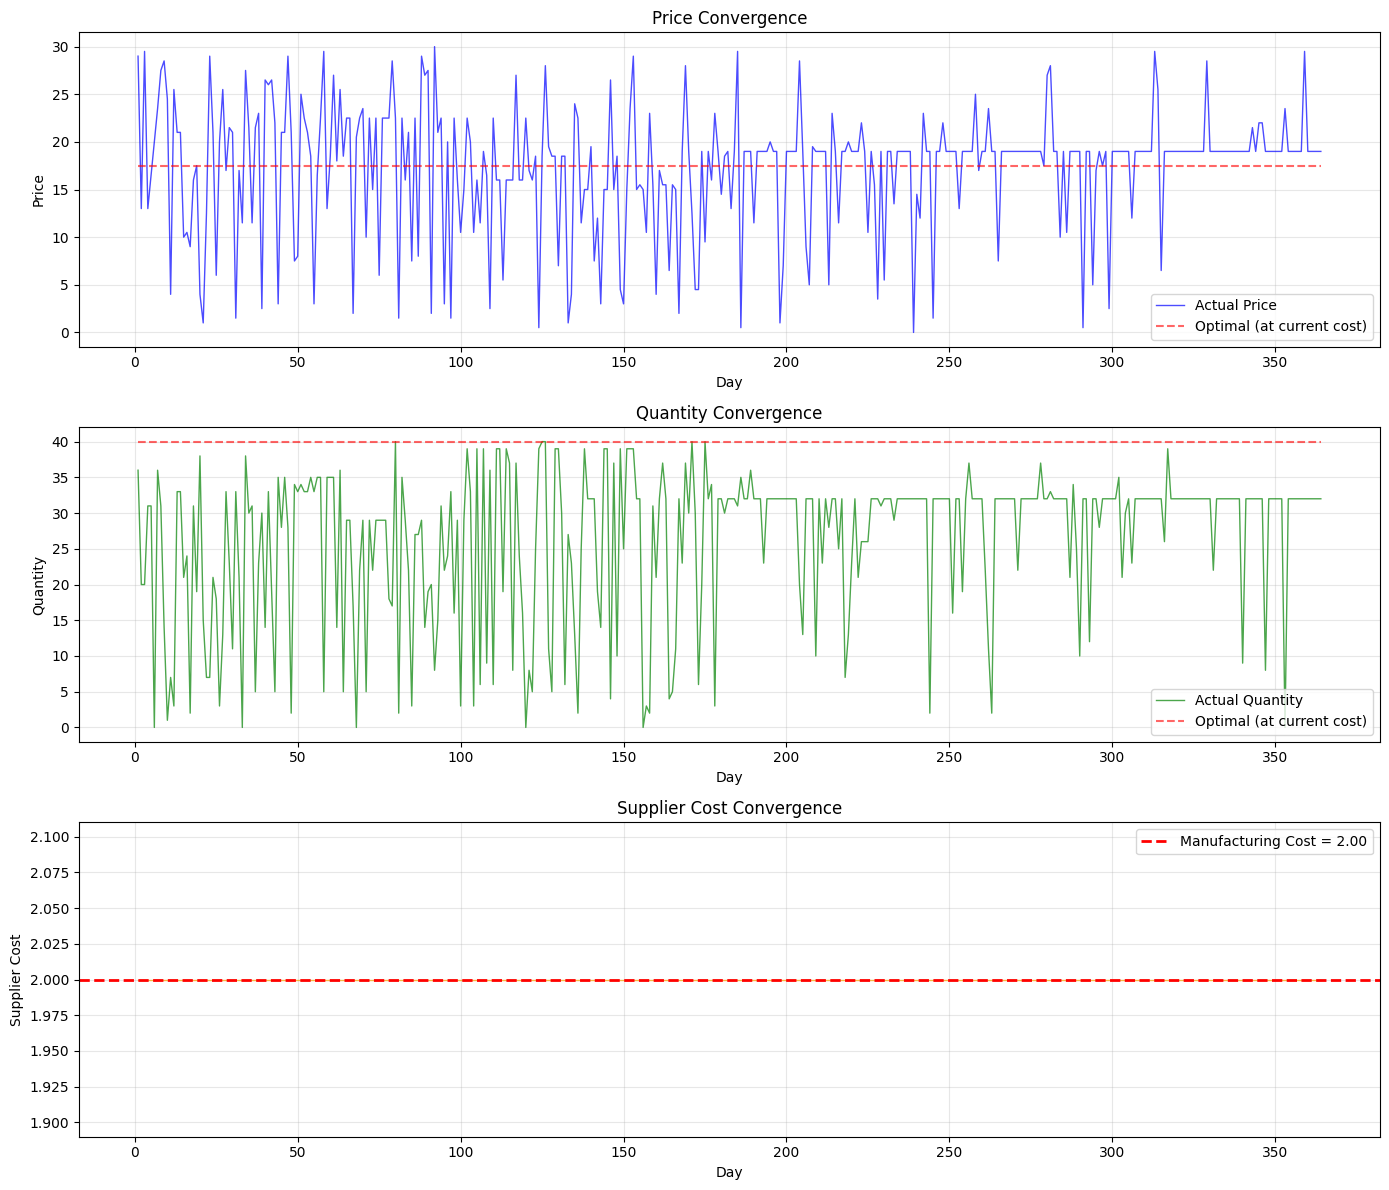

In [5]:
# Separate price, quantity, and supplier cost data
df = agent_df.reset_index()

price_data = df[df["AgentID"] == 1][["Step", "Action", "Reward"]].rename(columns={"Action": "Price"})
qty_data = df[df["AgentID"] == 2][["Step", "Action"]].rename(columns={"Action": "Quantity"})
supplier_data = df[df["AgentID"] == 3][["Step", "Action", "Reward"]].rename(columns={"Action": "Cost", "Reward": "Supplier_Reward"})

combined_df = pd.merge(price_data, qty_data, on="Step")
combined_df = pd.merge(combined_df, supplier_data, on="Step")
combined_df = pd.merge(combined_df, model_df, left_on="Step", right_index=True)

# Compute dynamic optimal values based on actual supplier cost evolution
combined_df['Optimal_Profit'] = combined_df['Cost'].apply(lambda c: params.PROFIT_OPTIMA_MAP.get(c, max(params.PROFIT_OPTIMA_MAP.values())))
combined_df['Optimal_Price'] = combined_df['Cost'].apply(lambda c: params.P_OPTIMA_MAP.get(c, 0))
combined_df['Optimal_Quantity'] = combined_df['Cost'].apply(lambda c: params.Q_OPTIMA_MAP.get(c, 0))

# Plot: Price, Quantity, and Cost Convergence
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 12))

# Price
ax1.plot(combined_df['Step'], combined_df['Price'], color='blue', alpha=0.7, linewidth=1, label='Actual Price')
ax1.plot(combined_df['Step'], combined_df['Optimal_Price'], color='red', linestyle='--', linewidth=1.5, alpha=0.6, label='Optimal (at current cost)')
ax1.set_xlabel('Day')
ax1.set_ylabel('Price')
ax1.set_title('Price Convergence')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Quantity
ax2.plot(combined_df['Step'], combined_df['Quantity'], color='green', alpha=0.7, linewidth=1, label='Actual Quantity')
ax2.plot(combined_df['Step'], combined_df['Optimal_Quantity'], color='red', linestyle='--', linewidth=1.5, alpha=0.6, label='Optimal (at current cost)')
ax2.set_xlabel('Day')
ax2.set_ylabel('Quantity')
ax2.set_title('Quantity Convergence')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Supplier Cost
ax3.plot(combined_df['Step'], combined_df['Cost'], color='orange', alpha=0.7, linewidth=1)
ax3.axhline(params.MANUFACTURING_COST, color='red', linestyle='--', linewidth=2, label=f'Manufacturing Cost = {params.MANUFACTURING_COST:.2f}')
if not params.SUPPLIER_TEAM_PLAYER:
    ax3.axhline(params.SUPPLIER_OPTIMAL_COST, color='purple', linestyle='--', linewidth=2, label=f'Supplier Optimal = {params.SUPPLIER_OPTIMAL_COST:.2f}')
ax3.set_xlabel('Day')
ax3.set_ylabel('Supplier Cost')
ax3.set_title('Supplier Cost Convergence')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

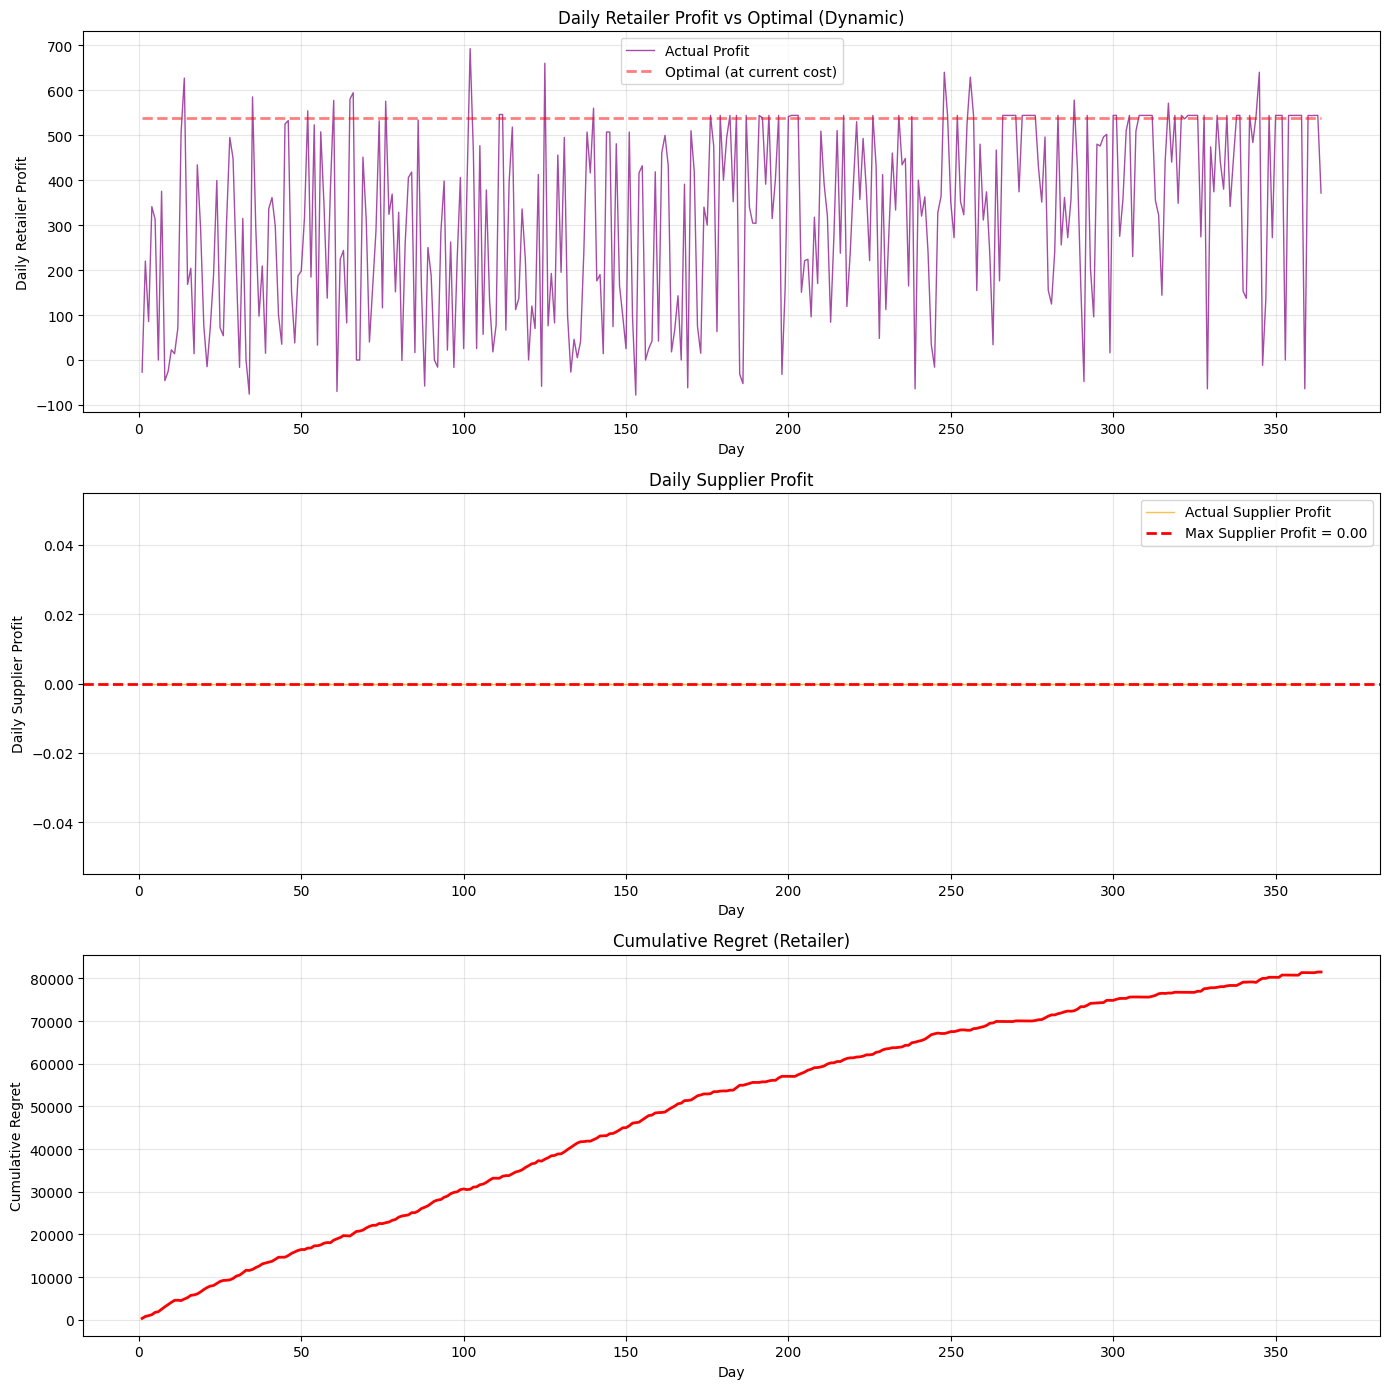

In [6]:
# Plot: Retailer Profit, Supplier Profit, and Cumulative Regret
fig, axes = plt.subplots(3, 1, figsize=(14, 14))

# Retailer Profit
axes[0].plot(combined_df['Step'], combined_df['Reward'], color='purple', alpha=0.7, linewidth=1, label='Actual Profit')
axes[0].plot(combined_df['Step'], combined_df['Optimal_Profit'], color='red', linestyle='--', linewidth=2, alpha=0.5, label='Optimal (at current cost)')
axes[0].set_xlabel('Day')
axes[0].set_ylabel('Daily Retailer Profit')
axes[0].set_title('Daily Retailer Profit vs Optimal (Dynamic)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Supplier Profit
axes[1].plot(combined_df['Step'], combined_df['Supplier_Reward'], color='orange', alpha=0.7, linewidth=1, label='Actual Supplier Profit')
axes[1].axhline(params.SUPPLIER_MAX_PROFIT, color='red', linestyle='--', linewidth=2, label=f'Max Supplier Profit = {params.SUPPLIER_MAX_PROFIT:.2f}')
axes[1].set_xlabel('Day')
axes[1].set_ylabel('Daily Supplier Profit')
axes[1].set_title('Daily Supplier Profit')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Cumulative Regret
cumulative_regret = combined_df['Regret'].cumsum()
axes[2].plot(combined_df['Step'], cumulative_regret, color='red', linewidth=2)
axes[2].set_xlabel('Day')
axes[2].set_ylabel('Cumulative Regret')
axes[2].set_title('Cumulative Regret (Retailer)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

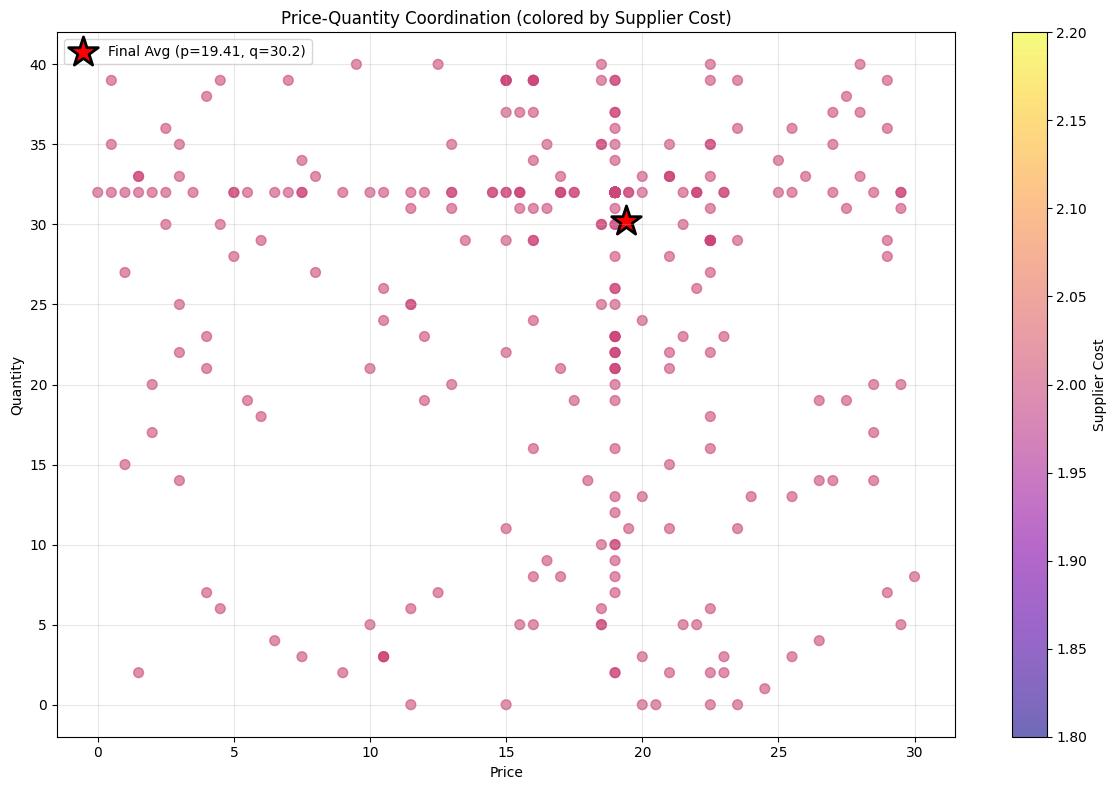

In [7]:
# Plot: Price-Quantity Coordination (color-coded by supplier cost)
fig, ax = plt.subplots(figsize=(12, 8))

scatter = ax.scatter(combined_df['Price'], combined_df['Quantity'], 
                     c=combined_df['Cost'], cmap='plasma', 
                     alpha=0.6, s=50)

# Mark final converged point
final_price = combined_df['Price'].iloc[-50:].mean()
final_qty = combined_df['Quantity'].iloc[-50:].mean()
ax.scatter([final_price], [final_qty], color='red', s=500, 
           marker='*', edgecolors='black', linewidths=2,
           label=f'Final Avg (p={final_price:.2f}, q={final_qty:.1f})')

plt.colorbar(scatter, ax=ax, label='Supplier Cost')
ax.set_xlabel('Price')
ax.set_ylabel('Quantity')
ax.set_title('Price-Quantity Coordination (colored by Supplier Cost)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()